In [2]:
import sys,os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 다양한 차트를 그려보기 위해서 
import datetime as dt # 시간을 나타내기 위해서
import json # JSON 데이터 처리하기 위해서
import folium # 지도를 그려보기 위해서 
from folium.plugins import MarkerCluster
plt.rcParams['font.family']='Malgun Gothic' # 차트에서 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False  # 차트에서 -기호 깨짐 방지

sys.path.append('c:/test')
os.chdir('c:/test')

In [3]:
def create_apt(filename):
    apt=pd.read_excel(filename)
    apt.columns=apt.iloc[0]
    apt.columns=['연번','단지명','용도','구청','행정동','주소','대지면적','연면적','건폐율','용적율',
                 '동수','층수','세대수','60이하','60~85','85초과','사업승인','사용검사','사업주체','시공자']
    apt.drop([0,1],inplace=True) # .drop([여기에 버리는 행을 리스트의 요소로 써야함!!])
    apt.set_index('연번',inplace=True) # 연번 칼럼의 value를 인덱스로 설정
    apt.fillna(0,inplace=True) # value값에 대해서 NAN 데이터 정수 0으로 처리해준다.
    apt['사용년도']=dt.date.today().year - pd.to_datetime([str(i) for i in apt['사용검사']]).year
    apt=apt[['단지명', '행정동', '주소', 
           '층수', '세대수', '60이하', '60~85', '85초과', '사업승인', '사용검사',  '사용년도']]
    return apt


In [4]:
# apt df 확인
apt = create_apt('공동주택현황_2023_3.xls')
apt.head()

,단지명,행정동,주소,층수,세대수,60이하,60~85,85초과,사업승인,사용검사,사용년도
연번,,,,,,,,,,,
1,동양맨션,진북동,진북동 417-47,5,180,0,90,90,1977-11-26 00:00:00,1978-07-05,45
2,삼우,서서학동,서서학동 372-50,5,120,0,120,0,1977-12-15 00:00:00,1978-11-02,45
3,기린(인후),인후1동,인후1가 530-1,5,100,100,0,0,1978-03-06 00:00:00,1978-11-02,45
4,거북연립,금암1동,금암동 752-3,4,32,1,31,0,1978-04-25 00:00:00,1978-11-07,45
5,동화연립,금암2동,금암2동 525-7,4,38,0,22,16,1979-06-20 00:00:00,1980-03-27,43


In [5]:

def create_local_df(start,end,locals): # 행정동()별 세대수 총합 구해보기 => 송천 1동, 송천 2동 모두 합해서 송천으로 구함
    r_apt=apt[(apt['사용년도']>=start) & (apt['사용년도']<=end)]
    temp=[]
    for local in locals:
        s=r_apt[r_apt['행정동'].str.contains(local)]['세대수'].sum()
        temp.append(s)
    local_df=pd.DataFrame(temp,index=locals)

    return local_df

local_df = create_local_df(20,30,['송천','평화'])
local_df

,0
송천,9092
평화,12954


In [6]:
def create_dong_df(start,end,locals): # 행정동별 세대수 총합 구해보기
    r_apt=apt[(apt['사용년도']>=start) & (apt['사용년도']<=end)]
    dongs_df= pd.DataFrame()
    for local in locals:
        dong=r_apt[r_apt['행정동'].str.contains(local)].groupby('행정동')['세대수'].sum()
        dongs_df=pd.concat([dongs_df,dong])
#     dongs_df.reset_index(inplace=True)
#     dongs_df.columns=['동','세대수']
    return dongs_df

dongs_df = create_dong_df(20,30,['송천','평화'])
dongs_df

,0
송천1동,4207.0
송천2동,4885.0
평화1동,1300.0
평화2동,11654.0


In [7]:
# 리모델링 수요는 보통 사용기간이 20~30년 사이에서 가장 많이 발생
start=20
end=30
locals=['효자','평화','송천','인후']
idx=locals
locals_df=pd.DataFrame(index=idx)
for i in range(8):
    df=create_local_df(start-i,end-i,locals)
  
    col_name=str(dt.date.today().year+i) + '년'
    df.columns=[col_name]
    # 왼쪽 df기준으로 정렬, 그리고 왼쪽 인덱스와 오른쪽 인덱스 비교하여 merge한다!
    locals_df=pd.merge(locals_df, df[col_name], how='left', left_index= True, right_index= True)
    
locals_df.dropna(how='all',inplace=True) # 모든 열의 값이 NA면 해당 행 버려라
locals_df.fillna(0,inplace=True) # 모든 열의 값은 아니지만 하나 이상의 값이 NA면 그 부분은 0으로 채우라는 의미
locals_df.sort_index(inplace=True) # 인덱스 기준 정렬
locals_df

,2023년,2024년,2025년,2026년,2027년,2028년,2029년,2030년
송천,9092,8062,7427,7573,7156,8025,5332,4555
인후,8098,8319,8319,9653,11174,11361,9338,5251
평화,12954,12944,14309,11489,9851,9363,7805,7332
효자,8213,7354,7161,7931,11869,10947,11298,11780


In [8]:
locals_df.loc['평균',:]=locals_df.mean() # 기본 axis=0 세로로 계산해줌 기본값이다 <인덱스에 추가>
# locals_df.loc[:,'평균']=locals_df.mean(axis=1) # axis=1 가로로 계산해줌 <칼럼에 추가>
# locals_df['평균'] = locals_df.mean(axis=1) <칼럼에 추가>

# locals_df['평균'].drop(inplace=True)
# locals_df.loc[:,'평균'].drop(inplace=True)
# del(locals_df['평균'])
# locals_df.drop(['평균'],inplace = True)
# locals_df.loc['평균',:].drop(inplace=True)
locals_df

,2023년,2024년,2025년,2026년,2027년,2028년,2029년,2030년
송천,9092.00,8062.00,7427.0,7573.0,7156.0,8025.0,5332.00,4555.0
인후,8098.00,8319.00,8319.0,9653.0,11174.0,11361.0,9338.00,5251.0
평화,12954.00,12944.00,14309.0,11489.0,9851.0,9363.0,7805.00,7332.0
효자,8213.00,7354.00,7161.0,7931.0,11869.0,10947.0,11298.00,11780.0
평균,9589.25,9169.75,9304.0,9161.5,10012.5,9924.0,8443.25,7229.5


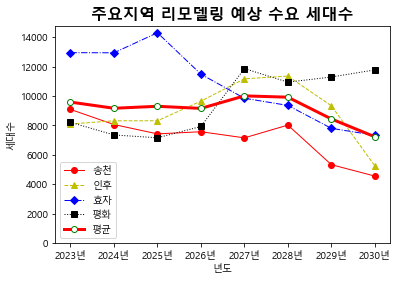

In [9]:
x = locals_df.columns
col='rybkg' * (len(locals_df.index)//5+1) #locals_df.index인 동의 개수가 많아질 수 있기 때문에 그 개수만큼 반복되기 위해 곱해줌
lines = ['-','--','-.',':'] * (len(locals_df.index)//4+1)
mak = 'o^Ds*>' * (len(locals_df.index)//6+1)
lables = ['송천','인후','효자','평화']

fig = plt.figure()
fig.set_facecolor('white')

for i in range(len(locals_df.index)-1):
    plt.plot(x,locals_df.iloc[i], marker = mak[i],lw=1,ls = lines[i],c = col[i],label = lables[i])    
plt.plot(x,locals_df.loc['평균'],c='r',lw=3, ls='-', marker='o',mfc='w',mec='g',label='평균')


font1 = { 'size': 16, 'color' :  'black', 'weight' : 'bold'}
plt.title("주요지역 리모델링 예상 수요 세대수",fontdict=font1)

plt.legend()
plt.xlabel('년도')
plt.ylabel('세대수')
plt.yticks([0,2000,4000,6000,8000,10000,12000,14000])

plt.show()


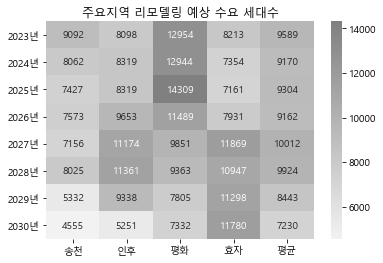

In [10]:
# sns.heatmap(locals_df, cmap=sns.light_palette(
#     "gray", as_cmap=True), annot=True, fmt=".0f")

sns.heatmap(locals_df.transpose(),annot=True,fmt=".0f",cmap=sns.light_palette(
    "gray", as_cmap=True))
plt.title("주요지역 리모델링 예상 수요 세대수")
plt.show()

In [11]:
# 리모델링 수요는 보통 사용기간이 20~30년 사이에서 가장 많이 발생
start=20
end=30
locals=['효자1동','효자3동','효자4동','효자5동','평화1동','평화2동','송천2동','송천1동','인후3동','인후2동','인후1동']
idx=locals
dongs_df=pd.DataFrame(index=idx)
for i in range(8):
    df=create_dong_df(start-i,end-i,locals)
    # print(df)
    col_name=str(dt.date.today().year+i) + '년'
    df.columns=[col_name]
    # 왼쪽 df기준으로 정렬, 그리고 왼쪽 인덱스와 오른쪽 인덱스 비교하여 merge한다!
    # print(df)
    dongs_df=pd.merge(dongs_df, df[col_name], how='left', left_index= True, right_index= True)
    # print(dongs_df)
dongs_df.dropna(how='all',inplace=True) # 모든 열의 값이 NA면 해당 행 버려라
# print(dongs_df)
dongs_df.fillna(0,inplace=True) # 모든 열의 값은 아니지만 하나 이상의 값이 NA면 그 부분은 0으로 채우라는 의미
dongs_df.sort_index(inplace=True) # 인덱스 기준 정렬
dongs_df

,2023년,2024년,2025년,2026년,2027년,2028년,2029년,2030년
송천1동,4207.0,3959.0,3684.0,3436.0,3019.0,3092.0,2779.0,2779.0
송천2동,4885.0,4103.0,3743.0,4137.0,4137.0,4933.0,2553.0,1776.0
인후1동,28.0,249.0,249.0,1583.0,3104.0,3755.0,3755.0,3755.0
인후2동,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
인후3동,8039.0,8039.0,8039.0,8039.0,8039.0,7575.0,5552.0,1465.0
평화1동,1300.0,1300.0,1300.0,1800.0,1304.0,816.0,816.0,816.0
평화2동,11654.0,11644.0,13009.0,9689.0,8547.0,8547.0,6989.0,6516.0
효자1동,1247.0,748.0,748.0,1118.0,1118.0,1118.0,1118.0,1118.0
효자3동,3655.0,3295.0,1795.0,2055.0,2055.0,1133.0,898.0,898.0
효자4동,328.0,328.0,1635.0,1775.0,3886.0,3886.0,4472.0,6578.0


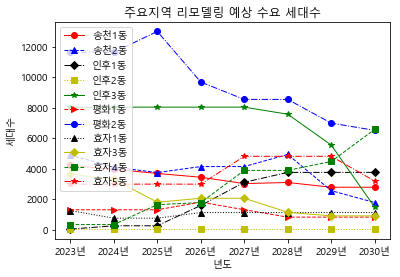

In [12]:
x = dongs_df.columns
col='rbkyg'*(len(dongs_df)//5+1)
lines=['-','--','-.',':']*(len(dongs_df)//4+1)
mak='o^Ds*>'*(len(dongs_df)//6+1)
labels=dongs_df.index
fig = plt.figure()
fig.set_facecolor('white')
# 선 그래프 그리기
for i in range(len(dongs_df)):
    y=dongs_df.iloc[i]
    plt.plot(x, y, c=col[i],lw=1, ls=lines[i], marker=mak[i],label=labels[i]) # ms=15, mec="g", mew=5, mfc="r"
plt.title("주요지역 리모델링 예상 수요 세대수")
# plt.ylim(3000, 15000)
plt.xlabel("년도")
plt.ylabel("세대수")
plt.legend()#jn에서만 일어나는 에러일 수 있음
plt.show()


In [53]:
# 2030년 리모델링 동 별 수요 구해보기
# latitude = 35.8242238      # 전주시청 위도
# longitude = 127.1479532   # 전주시청 경도

def create_geo(locals):
    with open('c:/test/hangjeongdong_전라북도.geojson',mode='rt',encoding='utf-8') as f:
        geo = json.loads(f.read())
        
    s_geo = {
        'type': 'FeatureCollection',
        'name': 'temp',
        'crs': {'type': 'name',
        'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
        'features': []
    }
    
    for i in geo['features']:
        if i['properties']['adm_nm'].split()[-1] in locals:
            i['properties']['adm_nm'] = i['properties']['adm_nm'].split()[-1]
            s_geo['features'].append(i)
            
    return s_geo

def create_map(locals,data_df,data_col):
    m = folium.Map([35.8242238,127.1479532],zoom_start=12,width=700,height=500)
    
    s_geo=create_geo(locals)

    folium.GeoJson(
        s_geo, # 경계선 그리는 JSON데이터(ex)행정구역등..)
        name='jb_municipalities'
    ).add_to(m)
    
    folium.Choropleth(
        geo_data=s_geo, # s_geo라는 JSON 데이터를 기반으로 경계선 안에 색을 표시한다
        data=data_df, # 데이터는 data_df(dongs_df)로 함
        columns=(data_df.index,data_col), # key_on과 매핑되는 값은 data_df.index(지역명)이다. 그리고 data_col은 표현하고자 하는 수치의 칼럼명을 써준다.
        key_on='properties.adm_nm', # s_geo라는 JSON 데이터의 'featurea' 키값의 'properties' 키 값의 'adm_nm'의 키"값"이 매핑 대상이됨.   
        fill_color='BuPu', # 색 지정
        legend_name=data_col, # 범례명은 data_col이다.
    ).add_to(m)
    return m

m = create_map(locals,dongs_df,'2030년')

m






In [52]:
def create_geo(locals):
    # 행정구역명에 locals = ['송천','인후','서신'] 이런 형태로 되어있어서 '전주'라는 단어와 locals의 요소들을 포함하고 있는 것들의 행정코드를 리스트로 만든 것
    jb=pd.read_excel('전라북도행정구역코드A.xlsx')
    jb_code=list(jb[jb['행정구역명'].str.contains('|'.join(locals)) & 
                   jb['행정구역명'].str.contains('전주')]['행정코드'])
    with open('c:/test/hangjeongdong_전라북도.geojson',mode='rt',encoding='utf-8') as f:
        geo = json.loads(f.read())
        
    s_geo={'type': 'FeatureCollection',
           'name': 'temp',
           'crs': {'type': 'name',
                   'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
           'features': []}
    
    for f in geo['features']:
        if int(f['properties']['adm_cd2']) in jb_code:
            f['properties']['adm_nm']=f['properties']['adm_nm'].split()[-1]
            s_geo['features'].append(f)
    return s_geo

def create_folium(locals,data_df,idx_col,data_col):
    latitude = 35.8242238      # 전주시청 위도
    longitude = 127.1479532   # 전주시청 경도
    m = folium.Map(location=[latitude, longitude],
                   zoom_start=12, 
                   width=750, 
                   height=500
                  )
    s_geo=create_geo(locals)

    folium.GeoJson(
        s_geo,
        name='jb_municipalities'
    ).add_to(m)
    
    folium.Choropleth(
        geo_data=s_geo,
        data=data_df,
        columns=(idx_col,data_col),
        key_on='properties.adm_nm',
        fill_color='BuPu',
        legend_name=data_col,
    ).add_to(m)
    return m

m=create_folium(locals,dongs_df,dongs_df.index,'2030년')
m